In [47]:
#################### Import Modules ####################
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.transforms import ToTensor
from sklearn.svm import SVC
from sklearn.utils import check_random_state
import pickle
from prettytable import PrettyTable


# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
# Set the device globally
torch.set_default_device(device)

Device:  cpu


In [48]:
##################### Random Seed ######################
torch.manual_seed(42)
random_state = check_random_state(42)

In [49]:
###################### Load Data #######################
def load_data(labeled_size=100, batch_size=64, dataset="FashionMNIST"):
    if dataset == "FashionMNIST":
        train_dataset = FashionMNIST(root='./data', train=True, transform=ToTensor(), download=True)
        test_dataset = FashionMNIST(root='./data', train=False, transform=ToTensor())
    elif dataset == "MNIST":
        train_dataset = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
        test_dataset = MNIST(root='./data', train=False, transform=ToTensor())
    unlabeled_size = len(train_dataset) - labeled_size
    ul_train_dataset, l_train_dataset = random_split(train_dataset, [unlabeled_size, labeled_size])

    ul_train_loader = DataLoader(ul_train_dataset, batch_size=batch_size, shuffle=True)
    l_train_loader = DataLoader(l_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return ul_train_loader, l_train_loader, test_loader

3. Semi-Supervised Variational Autoencoder
http://arxiv.org/abs/1406.5298

In [50]:
##################### Build Model ######################
class M1(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(M1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, 2 * latent_dim),  # Two outputs for mean and log variance
            nn.Softplus()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Assuming input values are normalized between 0 and 1
        )

    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)

        # Decode
        x_recon = self.decoder(z)

        return x_recon, mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

class SVM:
    def __init__(self, kernel):
        self.model = None
        self.kernel = kernel

    def train(self, X, y):
        self.model = SVC(kernel=self.kernel)
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

In [51]:
####################### Helpers ########################
def compute_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def extract_m1_features(model, train_loader, device):
    X_train_features = []
    y_train_labels = []

    with torch.no_grad():
        for data, labels in train_loader:
            data = data.view(-1, 784).to(device)
            recon_x, mu, logvar = model(data)
            X_train_features.append(mu)
            y_train_labels.append(labels)

    X_train_features = torch.cat(X_train_features)
    y_train_labels = torch.cat(y_train_labels)

    return X_train_features, y_train_labels

def train_svm(svm, X_train_features, y_train_labels):
    svm.train(X_train_features, y_train_labels)

def evaluate_svm(model, svm, test_loader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(-1, 784).to(device)
            recon_x, mu, logvar = model(data)
            features = mu.cpu().numpy()
            predicted_labels = svm.predict(features)
            total += labels.size(0)
            correct += (predicted_labels == labels.numpy()).sum().item()

    return correct, total

In [52]:
##################### Train Model ######################
def train_m1_model(model, optimizer, train_loader, device, num_epochs, log_interval):
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1, 784).to(device)

            recon_x, mu, logvar = model(data)

            # Compute loss and optimize
            loss = compute_loss(recon_x, data, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))

In [53]:
################### Hyperparameters ####################
input_dim = 784
hidden_dim = 600
latent_dim = 50
batch_size = 64
learning_rate = 3e-4
momentum = 0.1
num_epochs = 100
log_interval = 100
N_labeled = (100, 600, 1000, 3000)
kernel = 'rbf'

In [54]:
######################## Main ##########################
results = []
for dataset in ["FashionMNIST", "MNIST"]:
    for n in N_labeled:
        # Initialize M1 model, Transductive SVM, optimizer, and data loaders
        m1_model = M1(input_dim, hidden_dim, latent_dim)
        svm = SVM(kernel)
        optimizer = torch.optim.RMSprop(m1_model.parameters(), lr=learning_rate, momentum=momentum)

        ul_train_loader, l_train_loader, test_loader = load_data(labeled_size=n, batch_size=batch_size, dataset=dataset)
        # Train M1 model
        train_m1_model(m1_model, optimizer, ul_train_loader, device, num_epochs, log_interval)
        torch.save(m1_model.state_dict(), f'./checkpoints/M1_+_SVM/{dataset}/M1_{n}labeled.pth')

        # Extract features from M1 model for SVM
        X_train_features, y_train_labels = extract_m1_features(m1_model, l_train_loader, device)

        # Train SVM
        train_svm(svm, X_train_features, y_train_labels)
        with open(f'./checkpoints/M1_+_SVM/{dataset}/svm_{n}labeled.pkl','wb') as f:
            pickle.dump(svm,f)

        # Evaluate SVM
        correct, total = evaluate_svm(m1_model, svm, test_loader, device)
        accuracy = 100 * correct / total
        print(f'Accuracy of the SVM on the test images with {n} labeled images: {accuracy}%')

        results.append([dataset, n, accuracy, round(100 - accuracy,2)])
        

Epoch [1/100], Step [1/936], Loss: 38252.8516
Epoch [1/100], Step [101/936], Loss: 21494.0391
Epoch [1/100], Step [201/936], Loss: 19981.9492
Epoch [1/100], Step [301/936], Loss: 21149.5254
Epoch [1/100], Step [401/936], Loss: 20780.9219
Epoch [1/100], Step [501/936], Loss: 19600.6875
Epoch [1/100], Step [601/936], Loss: 19764.6328
Epoch [1/100], Step [701/936], Loss: 18280.0723
Epoch [1/100], Step [801/936], Loss: 18461.3223
Epoch [1/100], Step [901/936], Loss: 18068.8477
Epoch [2/100], Step [1/936], Loss: 18606.6367
Epoch [2/100], Step [101/936], Loss: 17816.9629
Epoch [2/100], Step [201/936], Loss: 19391.3887
Epoch [2/100], Step [301/936], Loss: 18458.3906
Epoch [2/100], Step [401/936], Loss: 18550.2168
Epoch [2/100], Step [501/936], Loss: 17516.8926
Epoch [2/100], Step [601/936], Loss: 18852.3008
Epoch [2/100], Step [701/936], Loss: 17672.6562
Epoch [2/100], Step [801/936], Loss: 17923.3203
Epoch [2/100], Step [901/936], Loss: 18566.1211
Epoch [3/100], Step [1/936], Loss: 18058.544

In [ ]:
#################### Print Results #####################
def print_results(results):
    table = PrettyTable()
    table.field_names = ["Dataset", "N", "Accuracy", "Percentage Error"]
    for r in results:
        table.add_row(r)

    print("Results table for M1 model + SVM")
    print(table)

print_results(results)

In [56]:
##################### Test Model #######################
def test():
    results = []
    for dataset in ["FashionMNIST", "MNIST"]:
        for n in N_labeled:
            ul_train_loader, l_train_loader, test_loader = load_data(labeled_size=n, batch_size=batch_size, dataset=dataset)

            m1_model = M1(input_dim, hidden_dim, latent_dim)
            svm = SVM(kernel)
            optimizer = torch.optim.RMSprop(m1_model.parameters(), lr=learning_rate, momentum=momentum)

            m1_model.load_state_dict(torch.load(f'./checkpoints/M1_+_SVM/{dataset}/M1_{n}labeled.pth'))
            m1_model.eval()
            with open(f'./checkpoints/M1_+_SVM/{dataset}/svm_{n}labeled.pkl', 'rb') as f:
                svm = pickle.load(f)

            correct, total = evaluate_svm(m1_model, svm, test_loader, device)
            accuracy = 100 * correct / total
            print(f'Accuracy of the SVM on the test images with {n} labeled images: {accuracy}%')

            results.append([dataset, n, accuracy, round(100 - accuracy,2)])
    
    print_results(results)
    

test()

Accuracy of the SVM on the test images with 100 labeled images: 65.09%
Accuracy of the SVM on the test images with 600 labeled images: 77.79%
Accuracy of the SVM on the test images with 1000 labeled images: 78.93%
Accuracy of the SVM on the test images with 3000 labeled images: 81.66%
Accuracy of the SVM on the test images with 100 labeled images: 76.66%
Accuracy of the SVM on the test images with 600 labeled images: 92.69%
Accuracy of the SVM on the test images with 1000 labeled images: 93.59%
Accuracy of the SVM on the test images with 3000 labeled images: 95.59%
Results table for M1 model + SVM
+--------------+------+----------+------------------+
|   Dataset    |  N   | Accuracy | Percentage Error |
+--------------+------+----------+------------------+
| FashionMNIST | 100  |  65.09   |      34.91       |
| FashionMNIST | 600  |  77.79   |      22.21       |
| FashionMNIST | 1000 |  78.93   |      21.07       |
| FashionMNIST | 3000 |  81.66   |      18.34       |
|    MNIST     | 

4. DCGAN and WGAN
https://arxiv.org/pdf/1704.00028

DCGAN

In [14]:
#################### Import Modules ####################
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision.datasets import FashionMNIST, MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
# Set the device globally
torch.set_default_device(device)

Device:  cpu


In [15]:
###################### Random Seed #####################
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  42


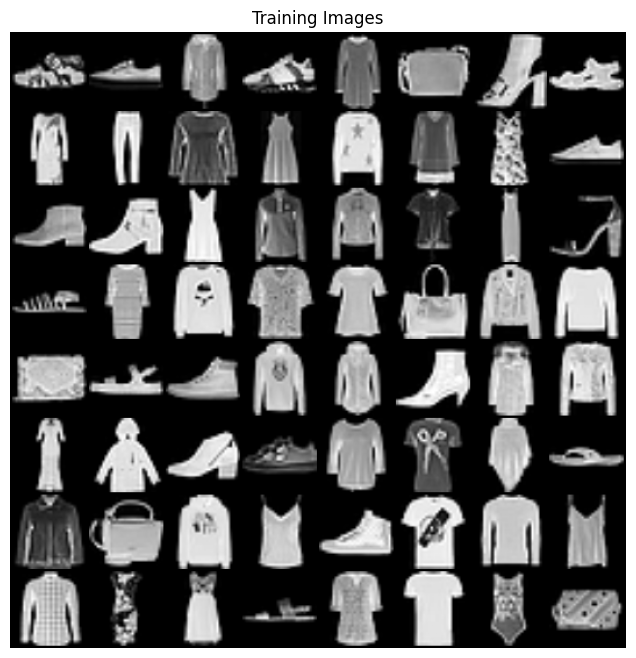

In [16]:
###################### Load Data #######################
def load_data(batch_size=64, dataset="FashionMNIST", show=False):
    transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, )),
        ])
    if dataset == "FashionMNIST":
        train_dataset = FashionMNIST(root='./data', train=True, transform=transform, download=True)
    elif dataset == "MNIST":
        train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    if show:
        real_batch = next(iter(train_dataloader))
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
        plt.show()

    return train_dataloader

_ = load_data(show=True)

In [6]:
#################### Hyperparameters ###################
batch_size = 64
image_size = 64
n_channels = 1
z_latent_vector_size = 100
generator_features_size = 64
discriminator_features_size = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
real_label = 1
fake_label = 0

In [7]:
##################### Weights Init #####################
# custom weights initialization called on Generator and Descriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
##################### DCGAN Model ######################
###################### Generator #######################
class Generator(nn.Module):
    def __init__(self, 
                 z_latent_vector_size, 
                 generator_features_size,
                 n_channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_latent_vector_size, generator_features_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_features_size * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(generator_features_size * 8, generator_features_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features_size * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(generator_features_size * 4, generator_features_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features_size * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(generator_features_size * 2, generator_features_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features_size),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(generator_features_size, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

#################### Discriminator #####################
class Discriminator(nn.Module):
    def __init__(self, 
                 discriminator_features_size,
                 n_channels,
                 gan_type="DCGAN"):
        super(Discriminator, self).__init__()
        if gan_type == "DCGAN":
            self.main = nn.Sequential(
                # input is ``(nc) x 64 x 64``
                nn.Conv2d(n_channels, discriminator_features_size, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. ``(ndf) x 32 x 32``
                nn.Conv2d(discriminator_features_size, discriminator_features_size * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(discriminator_features_size * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. ``(ndf*2) x 16 x 16``
                nn.Conv2d(discriminator_features_size * 2, discriminator_features_size * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(discriminator_features_size * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. ``(ndf*4) x 8 x 8``
                nn.Conv2d(discriminator_features_size * 4, discriminator_features_size * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(discriminator_features_size * 8),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. ``(ndf*8) x 4 x 4``
                nn.Conv2d(discriminator_features_size * 8, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
        elif gan_type == "WGAN":
            self.main = nn.Sequential(
                # input is ``(nc) x 64 x 64``
                nn.Conv2d(n_channels, discriminator_features_size, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(discriminator_features_size, affine=True),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. ``(ndf) x 32 x 32``
                nn.Conv2d(discriminator_features_size, discriminator_features_size * 2, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(discriminator_features_size * 2, affine=True),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. ``(ndf*2) x 16 x 16``
                nn.Conv2d(discriminator_features_size * 2, discriminator_features_size * 4, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(discriminator_features_size * 4, affine=True),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. ``(ndf*4) x 8 x 8``
                nn.Conv2d(discriminator_features_size * 4, discriminator_features_size * 8, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(discriminator_features_size * 8, affine=True),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. ``(ndf*8) x 4 x 4``
                nn.Conv2d(discriminator_features_size * 8, 1, 4, 1, 0, bias=False),
            )

    def forward(self, input):
        return self.main(input)

In [9]:
########### Init Generator and Discriminator ############
def init_gen_dis(gan_type="DCGAN"):
    # Create the generator
    generator = Generator(z_latent_vector_size, generator_features_size, n_channels)
    generator = generator.to(device)

    # Apply the ``weights_init`` function to randomly initialize all weights
    #  to ``mean=0``, ``stdev=0.02``.
    generator.apply(weights_init)


    # Create the Discriminator
    discriminator = Discriminator(discriminator_features_size, n_channels, gan_type)
    discriminator = discriminator.to(device)

    # Apply the ``weights_init`` function to randomly initialize all weights
    # like this: ``to mean=0, stdev=0.2``.
    discriminator.apply(weights_init)

    return generator, discriminator

In [10]:
#################### Init Optimizers ####################
def init_optim(generator, discriminator, lr, beta1=0.5, beta2=0.999):
    # Initialize the ``BCELoss`` function
    criterion = nn.BCELoss()

    # Setup Adam optimizers for both G and D
    discriminator_optim = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    generator_optim = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

    return criterion, discriminator_optim, generator_optim

In [11]:
################### Train DCGAN Model ###################
def train_dcgan(dataloader, 
          generator, discriminator, 
          criterion, 
          discriminator_optim, generator_optim,
          fixed_noise):

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    
    print("Starting Training Loop")
    start_time = time()
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            discriminator.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = discriminator(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, z_latent_vector_size, 1, 1, device=device)
            # Generate fake image batch with G
            fake = generator(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = discriminator(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            discriminator_optim.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            generator.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Generate new batch of fake images
            noise = torch.randn(b_size, z_latent_vector_size, 1, 1, device=device)
            fake = generator(noise)
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = discriminator(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            generator_optim.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch+1, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                torch.save(generator.state_dict(), './checkpoints/DCGAN/G.pth')
                torch.save(discriminator.state_dict(), './checkpoints/DCGAN/D.pth')

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

    print(f"Finished Trainig. Runtime: {time()-start_time} seconds")
    
    return G_losses, D_losses

In [12]:
###################### Plot Losses ######################
def plot_losses(G_losses, D_losses, model_name="DCGAN"):
    plt.figure(figsize=(10,5))
    plt.title(f"Generator and Discriminator Loss - {model_name}")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Starting Training Loop
[1/100][0/938]	Loss_D: 2.0669	Loss_G: 0.5855	D(x): 0.4944	D(G(z)): 0.6656 / 0.6043
[1/100][50/938]	Loss_D: 0.1548	Loss_G: 2.5325	D(x): 0.9076	D(G(z)): 0.0430 / 0.1119
[1/100][100/938]	Loss_D: 1.2390	Loss_G: 0.1970	D(x): 0.9544	D(G(z)): 0.6696 / 0.8289
[1/100][150/938]	Loss_D: 3.0915	Loss_G: 0.0084	D(x): 0.9572	D(G(z)): 0.9447 / 0.9916
[1/100][200/938]	Loss_D: 2.7966	Loss_G: 0.0114	D(x): 0.9533	D(G(z)): 0.9292 / 0.9887
[1/100][250/938]	Loss_D: 1.8569	Loss_G: 0.0274	D(x): 0.9915	D(G(z)): 0.8348 / 0.9731
[1/100][300/938]	Loss_D: 1.8775	Loss_G: 0.0569	D(x): 0.9647	D(G(z)): 0.8312 / 0.9450
[1/100][350/938]	Loss_D: 1.4140	Loss_G: 0.1191	D(x): 0.9320	D(G(z)): 0.7317 / 0.8887
[1/100][400/938]	Loss_D: 1.3851	Loss_G: 0.0853	D(x): 0.9633	D(G(z)): 0.7350 / 0.9185
[1/100][450/938]	Loss_D: 1.3815	Loss_G: 0.1547	D(x): 0.9439	D(G(z)): 0.7246 / 0.8578
[1/100][500/938]	Loss_D: 0.5447	Loss_G: 0.8561	D(x): 0.9084	D(G(z)): 0.3474 / 0.4358
[1/100][550/938]	Loss_D: 0.9979	Loss_G: 0.636

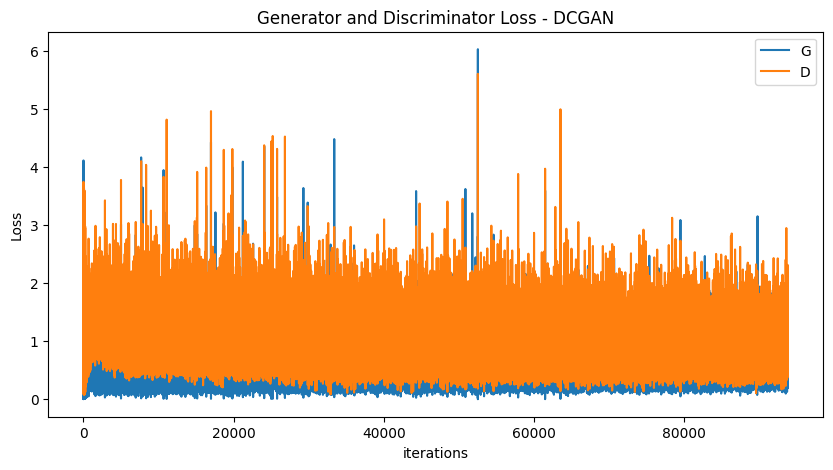

In [66]:
###################### DCGAN Main #######################
def main():
    train_dataloader = load_data(batch_size=64, dataset="FashionMNIST", show=False)

    generator, discriminator = init_gen_dis()

    criterion, discriminator_optim, generator_optim = init_optim(generator, 
                                                                 discriminator, 
                                                                 1e-4, 
                                                                 beta1)
    
    # Create batch of latent vectors that we will use to visualize
    # the progression of the generator
    fixed_noise = torch.randn(64, z_latent_vector_size, 1, 1, device=device)

    G_losses, D_losses = train_dcgan(train_dataloader, 
                               generator, 
                               discriminator, 
                               criterion, 
                               discriminator_optim, 
                               generator_optim,
                               fixed_noise)
    
    plot_losses(G_losses, D_losses)

main()

WGAN

In [1]:
##################### Import Modules ####################
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch import autograd
import time as t
import matplotlib.pyplot as plt
import os
from torchvision import utils
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST, MNIST
import torch.utils.data as data_utils

%matplotlib inline

SAVE_PER_TIMES = 100

In [2]:
####################### Load Data #######################
def get_data_loader(dataset, batch_size=64):

    if dataset == 'mnist':
        trans = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, )),
        ])
        train_dataset = MNIST(root='./data', train=True, download=True, transform=trans)
        test_dataset = MNIST(root='./data', train=False, download=True, transform=trans)

    elif dataset == 'fashion-mnist':
        trans = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, )),
        ])
        train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=trans)
        test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=trans)

    train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = data_utils.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader
        

In [3]:
####################### WGAN Model ######################
######################## Generator ######################
class WGANGenerator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [1024, 512, 256]
        # Input_dim = 100
        # Output_dim = C (number of channels)
        self.main_module = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=256, out_channels=channels, kernel_size=4, stride=2, padding=1))
            # output of main module --> Image (Cx32x32)

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

##################### Discriminator #####################
class WGANDiscriminator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx64x64)
        # Output_dim = 1
        self.main_module = nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(in_channels=channels, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
            # output of main module --> State (1024x4x4)

        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0))


    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

    def feature_extraction(self, x):
        # Use discriminator for feature extraction then flatten to vector of 16384
        x = self.main_module(x)
        return x.view(-1, 1024*4*4)


In [4]:
###################### WGAN Class #######################
class WGAN_GP(object):
    def __init__(self, 
                 channels, 
                 generator_iters,
                 critic_iters,
                 lambda_term,
                 learning_rate,
                 b1,
                 b2,
                 batch_size):
        print("WGAN_GradientPenalty init model.")
        self.G = WGANGenerator(channels)
        self.D = WGANDiscriminator(channels)
        self.C = channels

        # WGAN values from paper
        self.learning_rate = learning_rate
        self.b1 = b1
        self.b2 = b2
        self.batch_size = batch_size

        # WGAN_gradient penalty uses ADAM
        self.d_optimizer = optim.Adam(self.D.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))
        self.g_optimizer = optim.Adam(self.G.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))

        self.generator_iters = generator_iters
        self.critic_iter = critic_iters
        self.lambda_term = lambda_term


    def train(self, train_loader):
        self.t_begin = t.time()
        self.file = open("inception_score_graph.txt", "w")

        # Now batches are callable self.data.next()
        self.data = self.get_infinite_batches(train_loader)

        one = torch.tensor(1, dtype=torch.float)
        mone = one * -1

        G_losses = []
        D_losses = []

        for g_iter in range(self.generator_iters):
            # Requires grad, Generator requires_grad = False
            for p in self.D.parameters():
                p.requires_grad = True

            d_loss_real = 0
            d_loss_fake = 0
            Wasserstein_D = 0
            # Train Dicriminator forward-loss-backward-update self.critic_iter times while 1 Generator forward-loss-backward-update
            for d_iter in range(self.critic_iter):
                self.D.zero_grad()

                images = self.data.__next__()
                # Check for batch to have full batch_size
                if (images.size()[0] != self.batch_size):
                    continue

                z = torch.rand((self.batch_size, 100, 1, 1))

                # Train discriminator
                # WGAN - Training discriminator more iterations than generator
                # Train with real images
                d_loss_real = self.D(images)
                d_loss_real = d_loss_real.mean()
                d_loss_real.backward(mone)

                # Train with fake images
                z = Variable(torch.randn(self.batch_size, 100, 1, 1))

                fake_images = self.G(z)
                d_loss_fake = self.D(fake_images)
                d_loss_fake = d_loss_fake.mean()
                d_loss_fake.backward(one)

                # Train with gradient penalty
                gradient_penalty = self.calculate_gradient_penalty(images.data, fake_images.data)
                gradient_penalty.backward()


                d_loss = d_loss_fake - d_loss_real + gradient_penalty
                Wasserstein_D = d_loss_real - d_loss_fake
                self.d_optimizer.step()
                print(f'  Discriminator iteration: {d_iter+1}/{self.critic_iter}, loss_fake: {d_loss_fake:.2f}, loss_real: {d_loss_real:.2f}')

            # Generator update
            for p in self.D.parameters():
                p.requires_grad = False  # to avoid computation

            self.G.zero_grad()
            # train generator
            # compute loss with fake images
            z = Variable(torch.randn(self.batch_size, 100, 1, 1))
            fake_images = self.G(z)
            g_loss = self.D(fake_images)
            g_loss = g_loss.mean()
            g_loss.backward(mone)
            self.g_optimizer.step()
            print(f'Generator iteration: {g_iter+1}/{self.generator_iters}, g_loss: {g_loss:.2f}, d_loss: {d_loss:.2f}')

            G_losses.append(-g_loss.item())
            D_losses.append(d_loss.item())
               

            # Saving model and sampling images every SAVE_PER_TIMES generator iterations
            if (g_iter) % SAVE_PER_TIMES == 0:
                self.save_model()


        self.t_end = t.time()
        print('Time of training-{}'.format((self.t_end - self.t_begin)))

        # Save the trained parameters
        self.save_model()

        return G_losses, D_losses

    def evaluate(self, test_loader, D_model_path, G_model_path):
        self.load_model(D_model_path, G_model_path)
        z = Variable(torch.randn(self.batch_size, 100, 1, 1))
        samples = self.G(z)
        samples = samples.mul(0.5).add(0.5)
        samples = samples.data.cpu()
        grid = utils.make_grid(samples)
        print("Grid of 8x8 images saved to 'dgan_model_image.png'.")
        utils.save_image(grid, 'dgan_model_image.png')


    def calculate_gradient_penalty(self, real_images, fake_images):
        eta = torch.FloatTensor(self.batch_size,1,1,1).uniform_(0,1)
        eta = eta.expand(self.batch_size, real_images.size(1), real_images.size(2), real_images.size(3))

        interpolated = eta * real_images + ((1 - eta) * fake_images)

        # define it to calculate gradient
        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(
                                   prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # flatten the gradients to it calculates norm batchwise
        gradients = gradients.view(gradients.size(0), -1)
        
        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.lambda_term
        return grad_penalty

    def generate_img(self, z, number_of_images):
        samples = self.G(z).data.cpu().numpy()[:number_of_images]
        generated_images = []
        for sample in samples:
            if self.C == 3:
                generated_images.append(sample.reshape(self.C, 32, 32))
            else:
                generated_images.append(sample.reshape(32, 32))
        return generated_images

    def save_model(self):
        torch.save(self.G.state_dict(), './checkpoints/WGAN/G.pth')
        torch.save(self.D.state_dict(), './checkpoints/WGAN/D.pth')
        print('Models save to ./G.pth & ./D.pth ')

    def load_model(self, D_model_filename, G_model_filename):
        D_model_path = os.path.join(os.getcwd(), D_model_filename)
        G_model_path = os.path.join(os.getcwd(), G_model_filename)
        self.D.load_state_dict(torch.load(D_model_path))
        self.G.load_state_dict(torch.load(G_model_path))
        print('Generator model loaded from {}.'.format(G_model_path))
        print('Discriminator model loaded from {}-'.format(D_model_path))

    def get_infinite_batches(self, data_loader):
        while True:
            for i, (images, _) in enumerate(data_loader):
                yield images

WGAN_GradientPenalty init model.
  Discriminator iteration: 0/5, loss_fake: -0.03, loss_real: 0.30
  Discriminator iteration: 1/5, loss_fake: -1.71, loss_real: 4.94
  Discriminator iteration: 2/5, loss_fake: -3.61, loss_real: 8.89
  Discriminator iteration: 3/5, loss_fake: -5.34, loss_real: 10.92
  Discriminator iteration: 4/5, loss_fake: -6.73, loss_real: 12.97
Generator iteration: 0/7000, g_loss: -8.05, d_loss: -16.06
Models save to ./G.pth & ./D.pth 
  Discriminator iteration: 0/5, loss_fake: 5.40, loss_real: 13.86
  Discriminator iteration: 1/5, loss_fake: -0.03, loss_real: 14.91
  Discriminator iteration: 2/5, loss_fake: -6.86, loss_real: 15.43
  Discriminator iteration: 3/5, loss_fake: -11.39, loss_real: 16.69
  Discriminator iteration: 4/5, loss_fake: -13.49, loss_real: 16.39
Generator iteration: 1/7000, g_loss: -15.77, d_loss: -26.25
  Discriminator iteration: 0/5, loss_fake: -5.23, loss_real: 17.66
  Discriminator iteration: 1/5, loss_fake: -11.96, loss_real: 18.38
  Discrimin

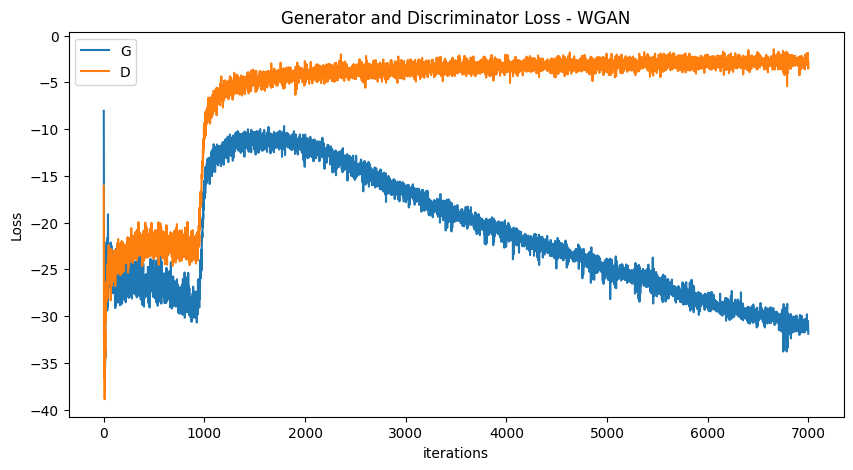

In [15]:
####################### WGAN Main #######################
def main():
    train_loader, test_loader = get_data_loader('fashion-mnist')

    model = WGAN_GP(channels=1, 
                    generator_iters=7000, 
                    critic_iters=5, 
                    lambda_term=10,
                    learning_rate=1e-4,
                    b1=0.5,
                    b2=0.999,
                    batch_size=64)

    G_losses, D_losses = model.train(train_loader)

    plot_losses(G_losses, D_losses, "WGAN")

main()

c:\Python310\lib\site-packages\torch\_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


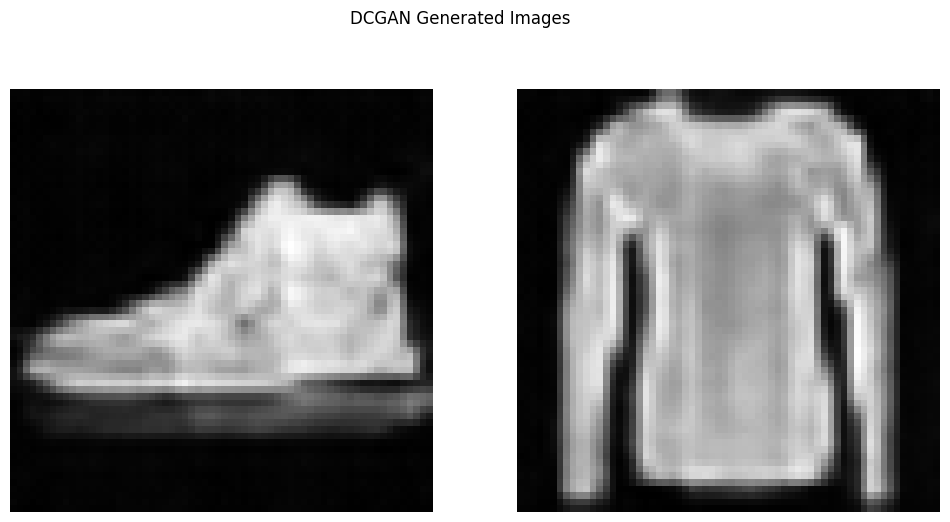

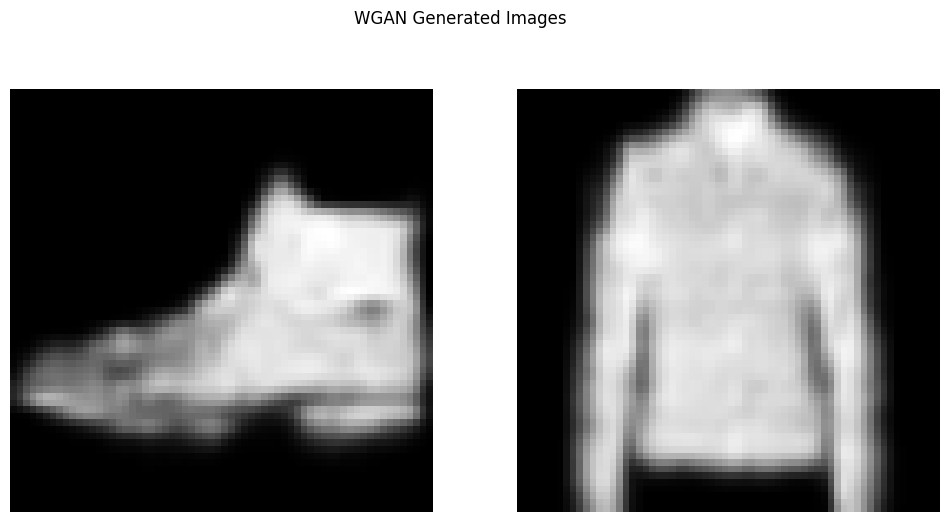

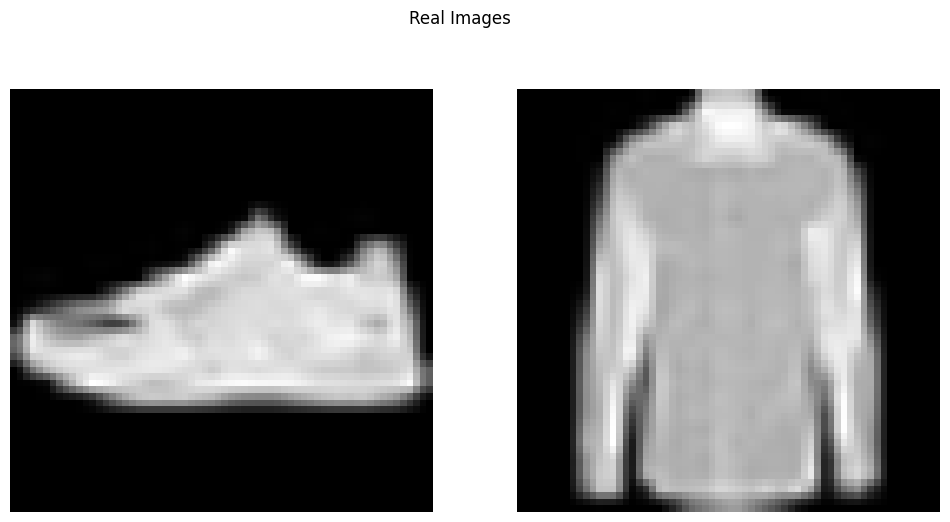

In [17]:
#################### Generate Images ####################
DCGAN_G = Generator(z_latent_vector_size, generator_features_size, n_channels)
DCGAN_G.load_state_dict(torch.load('./checkpoints/DCGAN/G.pth'))

WGAN_G = WGANGenerator(channels=1)
WGAN_G.load_state_dict(torch.load('./checkpoints/WGAN/G.pth'))

images = []
titles = ["DCGAN Generated Images", "WGAN Generated Images", "Real Images"]

with torch.no_grad():
    torch.manual_seed(42) # 42 for shirt and shoe
    z = torch.randn(2, z_latent_vector_size, 1, 1)
    fake_img_dcgan = DCGAN_G(z)
    for img in fake_img_dcgan:
        images.append(img.squeeze().detach().numpy())

    torch.manual_seed(987) # 987 for shirt and shoe
    z = Variable(torch.randn(2, 100, 1, 1))
    fake_img_wgan = WGAN_G(z)
    resize = transforms.Resize((64,64))
    for img in fake_img_wgan:
        images.append(resize(img).squeeze().detach().numpy())


torch.manual_seed(4) # 4 for shirt and shoe
train_dataloader = load_data(1)
for i in range(2):
    images.append(next(iter(train_dataloader))[0].resize(64,64))

images[0], images[1] = images[1], images[0]

iter_images = iter(images)
for title in titles:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    img = next(iter_images)
    axes[0].imshow(img, cmap='gray')
    axes[0].axis('off')
    
    img = next(iter_images)
    axes[1].imshow(img, cmap='gray')
    axes[1].axis('off')

    fig.suptitle(title)
    plt.show()
